In [2]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from astropy.io import fits
from astropy.table import Table
import subprocess
from pathlib import Path

from scipy.odr import ODR, Model, RealData

from dotenv import load_dotenv
load_dotenv(override=True)

ROOT_PATH = os.environ.get('ROOT_PATH')
if not ROOT_PATH in sys.path: sys.path.append(ROOT_PATH)

from src.utils.constants import *
from src.utils.CosmoFunc import *
from src.filepaths import GENRMOCKFP_TEMPLATE_FILEPATH, GENRMOCKFP_CPP_FILEPATH
from src.utils.functions import density_contour
from src.A_generate_mocks import generate_genrmockfp_file


def bin_data(x: np.array, y: np.array, xmin: float, xmax: float, n_bin: int):
    # x_bin = np.linspace(np.min(x), np.max(x), n_bin)
    x_bin = np.linspace(xmin, xmax, n_bin)
    x_middle = 0.5 * (x_bin[1:] + x_bin[:-1])
    delta_x = np.diff(x_bin)[0]

    x_bin_ = []
    y_bin = []
    y_bin_err = []
    y_bin_stderr = []

    for x_trial in x_middle:
        x_lower = x_trial - 0.5 * delta_x 
        x_upper = x_trial + 0.5 * delta_x

        y_ = y[(x >= x_lower) & (x < x_upper)]

        if len(y_):
            x_bin_.append(x_trial)
            y_bin.append(np.median(y_))
            y_bin_err.append(np.std(y_))
            y_bin_stderr.append(np.std(y_) / np.sqrt(len(y_)))
        else:
            continue

    return np.array(x_bin_), np.array(y_bin), np.array(y_bin_err), np.array(y_bin_stderr)

# Histogram

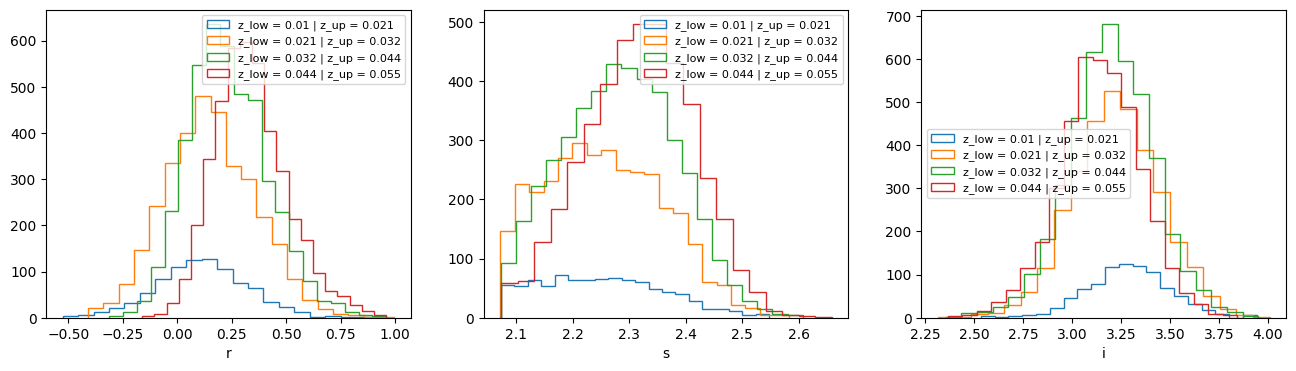

In [17]:
# Combine surveys
df_combined = pd.DataFrame()
for survey in ["6dFGS", "SDSS", "LAMOST"]:
    df_temp = pd.read_csv(f"../../data/foundation/logdist/smin_setting_1/fp_fit_method_0/{survey.lower()}.csv")
    df_temp["survey"] = survey
    df_combined = pd.concat([df_combined, df_temp], axis=0).reset_index(drop=True)

# Take redshift subsamples
z_edges = np.linspace(0.01, 0.055, 5)
z_bins = [(z_edges[i], z_edges[i+1]) for i in range(len(z_edges) - 1)]

fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(8 * 3 / 1.5, 6 / 1.5))
for i, (z_lower, z_upper) in enumerate(z_bins):
    df = df_combined.copy()
    df = df[(df["z_dist_est"] >= z_lower) & (df["z_dist_est"] < z_upper)]

    # Ax1: r
    ax1.hist(df["r"], bins=20, histtype="step", label=f"z_low = {np.round(z_lower, 3)} | z_up = {np.round(z_upper, 3)}")
    ax1.set_xlabel("r")
    ax1.legend(fontsize=8)


    # Ax2: s
    ax2.hist(df["s"], bins=20, histtype="step", label=f"z_low = {np.round(z_lower, 3)} | z_up = {np.round(z_upper, 3)}")
    ax2.set_xlabel("s")
    ax2.legend(fontsize=8)


    # Ax1: r
    ax3.hist(df["i"], bins=20, histtype="step", label=f"z_low = {np.round(z_lower, 3)} | z_up = {np.round(z_upper, 3)}")
    ax3.set_xlabel("i")
    ax3.legend(fontsize=8)

# 2D distribution

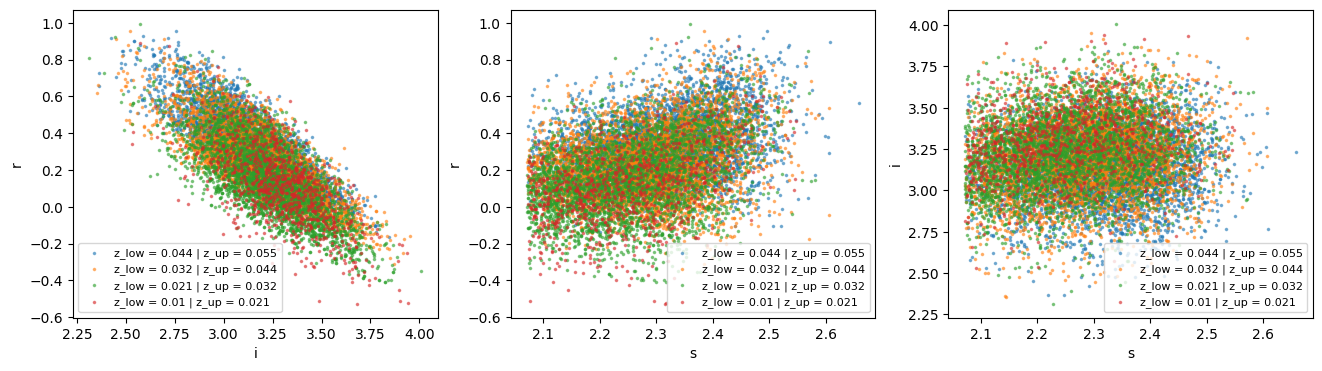

In [19]:
# Combine surveys
df_combined = pd.DataFrame()
for survey in ["6dFGS", "SDSS", "LAMOST"]:
    df_temp = pd.read_csv(f"../../data/foundation/logdist/smin_setting_1/fp_fit_method_0/{survey.lower()}.csv")
    df_temp["survey"] = survey
    df_combined = pd.concat([df_combined, df_temp], axis=0).reset_index(drop=True)

# Take redshift subsamples
z_edges = np.linspace(0.01, 0.055, 5)
z_bins = [(z_edges[i], z_edges[i+1]) for i in range(len(z_edges) - 1)]

# Combinations to plot
combos = [("i", "r"), ("s", "r"), ("s", "i")]

fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(8 * 3 / 1.5, 6 / 1.5))
for i, (z_lower, z_upper) in enumerate(z_bins[::-1]):

    df = df_combined.copy()
    df = df[(df["z_dist_est"] >= z_lower) & (df["z_dist_est"] < z_upper)]

    # Ax1: r vs i
    ax1.scatter(df["i"], df["r"], s=2.5, alpha=0.5, label=f"z_low = {np.round(z_lower, 3)} | z_up = {np.round(z_upper, 3)}")
    ax1.set_xlabel("i")
    ax1.set_ylabel("r")
    ax1.legend(fontsize=8)


    # Ax2: r vs s
    ax2.scatter(df["s"], df["r"], s=2.5, alpha=0.5, label=f"z_low = {np.round(z_lower, 3)} | z_up = {np.round(z_upper, 3)}")
    ax2.set_xlabel("s")
    ax2.set_ylabel("r")
    ax2.legend(fontsize=8)


    # Ax3: i vs s
    ax3.scatter(df["s"], df["i"], s=2.5, alpha=0.5, label=f"z_low = {np.round(z_lower, 3)} | z_up = {np.round(z_upper, 3)}")
    ax3.set_xlabel("s")
    ax3.set_ylabel("i")
    ax3.legend(fontsize=8)

# Plot param vs redshift

Text(0, 0.5, 'i')

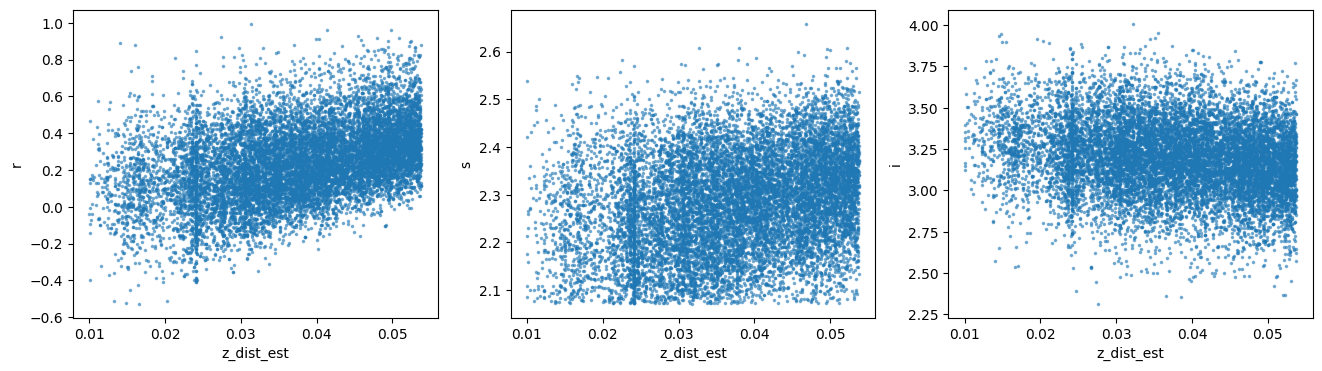

In [23]:
# Combine surveys
df_combined = pd.DataFrame()
for survey in ["6dFGS", "SDSS", "LAMOST"]:
    df_temp = pd.read_csv(f"../../data/foundation/logdist/smin_setting_1/fp_fit_method_0/{survey.lower()}.csv")
    df_temp["survey"] = survey
    df_combined = pd.concat([df_combined, df_temp], axis=0).reset_index(drop=True)

fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(8 * 3 / 1.5, 6 / 1.5))
df = df_combined.copy()

# Ax1: r vs z
ax1.scatter(df["z_dist_est"], df["r"], s=2.5, alpha=0.5)
ax1.set_xlabel("z_dist_est")
ax1.set_ylabel("r")


# Ax2: s vs z
ax2.scatter(df["z_dist_est"], df["s"], s=2.5, alpha=0.5)
ax2.set_xlabel("z_dist_est")
ax2.set_ylabel("s")


# Ax3: i vs z
ax3.scatter(df["z_dist_est"], df["i"], s=2.5, alpha=0.5)
ax3.set_xlabel("z_dist_est")
ax3.set_ylabel("i")